In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
from keras.layers import Flatten
import cv2, os

from keras.layers import MaxPooling2D

**TRAINING**

In [2]:
train_dir = r'../input/human-action-recognition-dataset/Structured/train'
test_dir = r'../input/human-action-recognition-dataset/Structured/test'

BATCH_SIZE = 64
NUM_CLASSES = 15
IMG_WIDTH, IMG_HEIGHT = 224, 224

In [3]:
#generating data
preprocess_fn = tf.keras.applications.resnet.preprocess_input

train_datagen = ImageDataGenerator(rescale= 1./255,
                                  horizontal_flip= True,
                                  width_shift_range= 0.05,
                                  height_shift_range= 0.1,
                                  rotation_range= 10,
                                  preprocessing_function= preprocess_fn
                                  )

test_datagen = ImageDataGenerator(rescale= 1./255,
                                 preprocessing_function= preprocess_fn)

train_generator = train_datagen.flow_from_directory(directory= train_dir,
                                                    target_size= (IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle = True,
                                                    color_mode = 'rgb',
                                                    subset = 'training',
                                                    class_mode = 'categorical',
                                                    seed = 2
                                                   )

test_generator = test_datagen.flow_from_directory(directory= test_dir,
                                                 target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size = BATCH_SIZE,
                                                 shuffle= False,
                                                 color_mode= 'rgb',
                                                 class_mode = 'categorical',
                                                 seed = 2)

Found 10710 images belonging to 15 classes.
Found 1890 images belonging to 15 classes.


In [5]:
base_model = tf.keras.applications.resnet.ResNet152(input_shape=(IMG_WIDTH,IMG_HEIGHT,3), weights='imagenet',
                                                    include_top=False)

base_model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [6]:
#creating model pipeline
def final_model(inputs):
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='classification')(x)
    
    return x

def compile_model():
    inputs = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    outputs  = final_model(inputs)
    model = tf.keras.Model(inputs= inputs, outputs= outputs)
    model.compile(optimizer= tf.keras.optimizers.SGD(0.001), loss='categorical_crossentropy',
                 metrics=['acc'])
    
    return model

In [7]:
#compiling model
model = compile_model()

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
classification (Dense)       (None, 15)                30735     
Total params: 58,401,679
Trainable params: 58,250,255
Non-trainable params: 151,424
_________________________________________________________________


In [9]:
#start training
checkpoint = tf.keras.callbacks.ModelCheckpoint('ResNet152_HAR-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5',
                                          save_best_only=True, monitor='val_acc', verbose=1)

#earlystopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss')

train_stats = model.fit(train_generator,
                        batch_size= BATCH_SIZE,
                        validation_data= test_generator,
                        validation_batch_size= BATCH_SIZE,
                        epochs= 50,
                        callbacks=[checkpoint]
                        )

Epoch 1/50


2022-08-09 15:21:57.190398: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


168/168 [==============================] - 292s 2s/step - loss: 2.6085 - acc: 0.1713 - val_loss: 3.0667 - val_acc: 0.0720

Epoch 00001: val_acc improved from -inf to 0.07196, saving model to ResNet152_HAR-001-0.171335-0.071958.h5
Epoch 2/50
168/168 [==============================] - 204s 1s/step - loss: 1.8255 - acc: 0.4398 - val_loss: 3.0299 - val_acc: 0.0698

Epoch 00002: val_acc did not improve from 0.07196
Epoch 3/50
168/168 [==============================] - 206s 1s/step - loss: 1.4325 - acc: 0.5702 - val_loss: 2.7708 - val_acc: 0.1661

Epoch 00003: val_acc improved from 0.07196 to 0.16614, saving model to ResNet152_HAR-003-0.570215-0.166138.h5
Epoch 4/50
168/168 [==============================] - 206s 1s/step - loss: 1.2211 - acc: 0.6354 - val_loss: 2.0946 - val_acc: 0.3640

Epoch 00004: val_acc improved from 0.16614 to 0.36402, saving model to ResNet152_HAR-004-0.635387-0.364021.h5
Epoch 5/50
168/168 [==============================] - 208s 1s/step - loss: 1.0808 - acc: 0.6738 - 

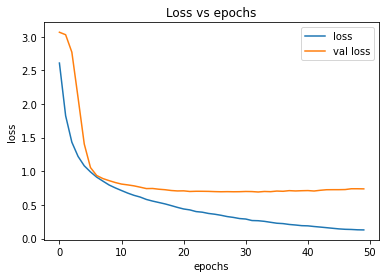

In [15]:
epochs = [i for i in range(50)]
plt.plot(epochs, train_stats.history['loss'], label='loss')
plt.plot(epochs, train_stats.history['val_loss'], label='val loss')

plt.title('Loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

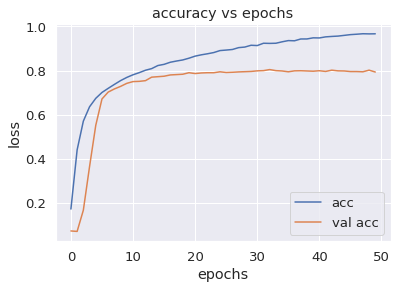

In [34]:
epochs = [i for i in range(50)]
plt.plot(epochs, train_stats.history['acc'], label= 'acc')
plt.plot(epochs, train_stats.history['val_acc'], label= 'val acc')

plt.title('accuracy vs epochs')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()
plt.show()

In [25]:
#saving trained model as json
model_json = model.to_json()
with open('ResNet152.json', 'w') as json_file:
    json_file.write(model_json)

print('Model saved')

Model saved


**TESTING**

In [19]:
#function to load test data
def create_test_generator(test_path):
    
    preprocess_fn = tf.keras.applications.resnet.preprocess_input
    SEED = 12
    IMG_HEIGHT = 224
    IMG_WIDTH = 224
    BATCH_SIZE = 64
    
    test_datagen = ImageDataGenerator(rescale= 1./255,
                                      preprocessing_function= preprocess_fn
                                     )
    
    test_generator = test_datagen.flow_from_directory(directory = test_path,
                                                       target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                        batch_size = BATCH_SIZE,
                                                        shuffle  = False , 
                                                        color_mode = "rgb",
                                                        class_mode = "categorical",
                                                        seed = 12
                                                      )
    
    return test_generator

In [21]:
def Load_Model(modelpath_json, weights_path):
    
    #loading the model
    json_file = open(modelpath_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    
    # load weights into new model
    loaded_model.load_weights(weights_path)
    print("Loaded model from disk")
    
    model = loaded_model
    clear_output()
    
    return model

def show_model_summary(model):
    
    model.summary()

In [22]:
def make_predictions(model, test_generator):
    
    preds = model.predict(test_generator)
    y_preds = np.argmax(preds , axis = 1)
    y_test = np.array(test_generator.labels)
    
    return y_preds, y_test

def classificn_report(y_test, y_preds):
    
    output_details = classification_report(y_test, y_preds, output_dict=True)
    print(classification_report(y_test, y_preds))
    return output_details

def generate_cm_data(y_test, y_preds):
    NUM_CLASSES = 15
    CLASS_LABELS  = ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting',
                    'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping',
                    'texting', 'using_laptop']
    
    cm_data = confusion_matrix(y_test , y_preds)
    cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
    
    all_mod_rows = []
    for i in range(NUM_CLASSES):
        row = cm.iloc[i]
        row_total = 0
        for k in range(NUM_CLASSES):
            row_total += row[k]
        mod_row = []
        for j in range(NUM_CLASSES):
            mod_row.append(round(row[j]/row_total, 2))
        all_mod_rows.append(np.array(mod_row))
    
    return pd.DataFrame(all_mod_rows, columns=CLASS_LABELS, index=CLASS_LABELS)

In [31]:
def show_predictions(test_path, y_preds):
    
    CLASS_LABELS  = ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting',
                    'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping',
                    'texting', 'using_laptop']
    IMG_HEIGHT = 224
    IMG_WIDTH = 224
    BATCH_SIZE = 64
    
    img_datagen = ImageDataGenerator(rescale = 1./255)
    img_generator = img_datagen.flow_from_directory(directory = test_path,
                                                       target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                        batch_size = BATCH_SIZE,
                                                        shuffle  = False , 
                                                        color_mode = "rgb",
                                                        class_mode = "categorical",
                                                        seed = 12
                                                      )
    clear_output()

    images, classes = next(img_generator)
    
    pred_lbls = [CLASS_LABELS[idx] for idx in y_preds]
    display_multiple_images(images, pred_lbls)
    
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_multiple_images(images, titles, title_colors=None):
    subplot = 991
    plt.figure(figsize=(15,15))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], subplot+i, color) 
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [24]:
#generating test data
test_path = r"../input/human-action-recognition-dataset/Structured/test"
test_generator = create_test_generator(test_path)

Found 1890 images belonging to 15 classes.


In [26]:
#loading saved model along with weights
model_path = r'./ResNet152.json'
weights_path = r'./ResNet152_HAR-033-0.923063-0.804233.h5'
model = Load_Model(model_path, weights_path)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
classification (Dense)       (None, 15)                30735     
Total params: 58,401,679
Trainable params: 58,250,255
Non-trainable params: 151,424
_________________________________________________________________


In [27]:
#predictions
y_preds, y_test = make_predictions(model, test_generator)
print('Done')

Done


In [28]:
#evaluating classification report
output_details = classificn_report(y_test, y_preds)

print('Accuracy', output_details['accuracy'])
# 0 --> calling
# 1 --> clapping
# 2 --> cycling
# 3 --> dancing
# 4 --> drinking
# 5 --> eating
# 6 --> fighting
# 7 --> hugging
# 8 --> laughing
# 9 --> listening_to_music
# 10 --> running
# 11 --> sitting
# 12 --> sleeping
# 13 --> texting
# 14 --> using_laptop

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       126
           1       0.87      0.72      0.79       126
           2       0.95      0.98      0.96       126
           3       0.82      0.78      0.80       126
           4       0.82      0.81      0.82       126
           5       0.91      0.92      0.92       126
           6       0.80      0.79      0.80       126
           7       0.78      0.82      0.80       126
           8       0.80      0.88      0.84       126
           9       0.65      0.73      0.69       126
          10       0.88      0.84      0.86       126
          11       0.64      0.63      0.64       126
          12       0.86      0.85      0.85       126
          13       0.81      0.69      0.75       126
          14       0.73      0.83      0.77       126

    accuracy                           0.80      1890
   macro avg       0.81      0.80      0.80      1890
weighted avg       0.81   

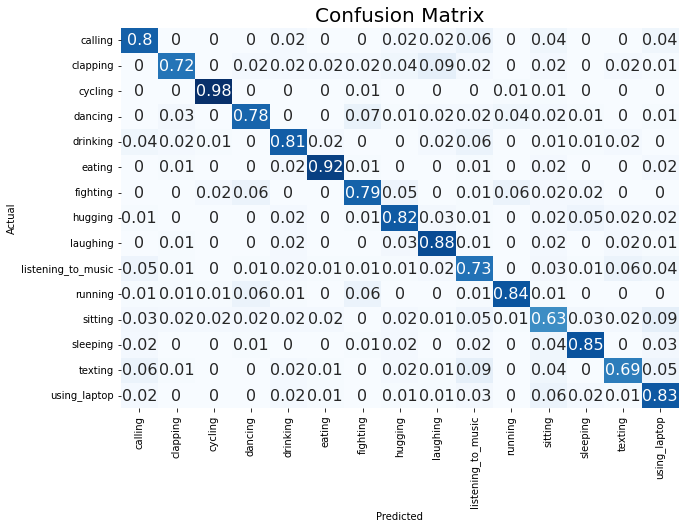

In [29]:
#plotting confusion matrix (in terms of recall scores)
cm = generate_cm_data(y_test, y_preds)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

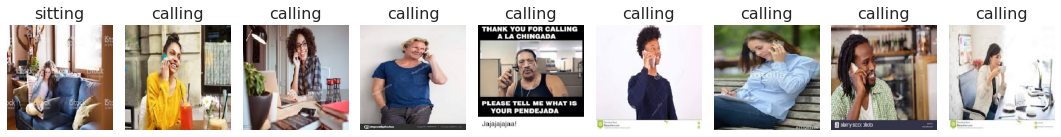

In [33]:
show_predictions(test_path, y_preds)